# Understanding Coronavirus in London

## 1. Introduction

Since it was first discovered in December 2019, the severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2), has had a massive impact as it has spread across the globe. The virus causes the disease known as COVID-19 and due to its novel appearance, there is great uncertainty surrounding its epidemiology, such as risk factors, transmission characteristics, and possible control measures. With such uncertainty and rapid onset, governments the world over have had no other option but to shut down their entire economies, confine their citizens under lockdown, and bide their time until an exit strategy can be found.

As of May 4th, 2020, there have been 24,988 total cases of COVID-19 in London, representing a significant outbreak of the disease. This report seeks to use demographic profile data, venue location data and coronavirus case data to examine outbreak trends across London’s 32 boroughs. Example questions to be answered are:  
-	Are deprived areas at more risk of developing COVID-19?
-	Are areas with an older population or those with higher BAME populations at greater risk of having more COVID-19 cases?  
-	Is prevalence increased by the number of certain venue types, e.g. pubs, restaurants, or parks? 

Findings from the investigation could be useful in informing how the capital defines and manages its exit from lockdown.

But first, let's get the dependencies out of the way.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
from geopy.geocoders import Nominatim 
import requests 
from pandas.io.json import json_normalize 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import folium 

print('Libraries imported.')

Libraries imported.


## 2. Data Collection, Understanding and Preparation

### 2.1 London Borough Profiles and Geolocation Data

Data for the London boroughs can be downloaded from the London Datastore, which has comprehensive data on several different metrics across the capital.

In [2]:
url_boro = "https://data.london.gov.uk/dataset/london-borough-profiles/resource/80647ce7-14f3-4e31-b1cd-d5f7ea3553be/download"

boro_data = pd.read_excel(url_boro,sheet_name="Data")
boro_data.dropna(inplace=True)
boro_data.head()

,Code,New code,Area name,Inner/ Outer London,GLA Population Estimate 2017,GLA Household Estimate 2017,Inland Area (Hectares),Population density (per hectare) 2017,"Average Age, 2017","Proportion of population aged 0-15, 2015","Proportion of population of working-age, 2015","Proportion of population aged 65 and over, 2015",Net internal migration (2015),Net international migration (2015),Net natural change (2015),% of resident population born abroad (2015),Largest migrant population by country of birth (2011),% of largest migrant population (2011),Second largest migrant population by country of birth (2011),% of second largest migrant population (2011),Third largest migrant population by country of birth (2011),% of third largest migrant population (2011),% of population from BAME groups (2016),% people aged 3+ whose main language is not English (2011 Census),"Overseas nationals entering the UK (NINo), (2015/16)","New migrant (NINo) rates, (2015/16)",Largest migrant population arrived during 2015/16,Second largest migrant population arrived during 2015/16,Third largest migrant population arrived during 2015/16,Employment rate (%) (2015),Male employment rate (2015),Female employment rate (2015),Unemployment rate (2015),Youth Unemployment (claimant) rate 18-24 (Dec-15),Proportion of 16-18 year olds who are NEET (%) (2014),Proportion of the working-age population who claim out-of-work benefits (%) (May-2016),% working-age with a disability (2015),Proportion of working age people with no qualifications (%) 2015,Proportion of working age with degree or equivalent and above (%) 2015,"Gross Annual Pay, (2016)",Gross Annual Pay - Male (2016),Gross Annual Pay - Female (2016),Modelled Household median income estimates 2012/13,% adults that volunteered in past 12 months (2010/11 to 2012/13),Number of jobs by workplace (2014),% of employment that is in public sector (2014),"Jobs Density, 2015","Number of active businesses, 2015",Two-year business survival rates (started in 2013),Crime rates per thousand population 2014/15,Fires per thousand population (2014),Ambulance incidents per hundred population (2014),"Median House Price, 2015","Average Band D Council Tax charge (£), 2015/16",New Homes (net) 2015/16 (provisional),"Homes Owned outright, (2014) %","Being bought with mortgage or loan, (2014) %","Rented from Local Authority or Housing Association, (2014) %","Rented from Private landlord, (2014) %","% of area that is Greenspace, 2005",Total carbon emissions (2014),"Household Waste Recycling Rate, 2014/15","Number of cars, (2011 Census)","Number of cars per household, (2011 Census)","% of adults who cycle at least once per month, 2014/15","Average Public Transport Accessibility score, 2014","Achievement of 5 or more A*- C grades at GCSE or equivalent including English and Maths, 2013/14",Rates of Children Looked After (2016),% of pupils whose first language is not English (2015),% children living in out-of-work households (2015),"Male life expectancy, (2012-14)","Female life expectancy, (2012-14)",Teenage conception rate (2014),Life satisfaction score 2011-14 (out of 10),Worthwhileness score 2011-14 (out of 10),Happiness score 2011-14 (out of 10),Anxiety score 2011-14 (out of 10),Childhood Obesity Prevalance (%) 2015/16,People aged 17+ with diabetes (%),Mortality rate from causes considered preventable 2012/14,Political control in council,Proportion of seats won by Conservatives in 2014 election,Proportion of seats won by Labour in 2014 election,Proportion of seats won by Lib Dems in 2014 election,Turnout at 2014 local elections
2,E09000002,E09000002,Barking and Dagenham,Outer London,209000.0,78188.4,3610.78,57.8822,32.9,27.2,63.1,9.7,-1176,2509,2356,37.8,Nigeria,4.67697,India,2.34736,Pakistan,2.33284,49.5318,18.7242,7538.0,59.139658,Romania,Bulgaria,Lithuania,65.8,75.6,56.5,11,4.49666,5.7,10.5287,17.2,11.3,32.2,27886,30104,24602,29420,20.5297,58900,21.104536,0.48,6560.0,73.0,83.3591,3.03015,13.6693,243500,1354.03,730,16.4379,27.3545,35.917

In [3]:
boro_data.shape

(32, 85)

Use geoPy to find latitude and longitude data for each of the London boroughs, then connect this data to the existing borough data.

In [4]:
geolocator = Nominatim(user_agent="ny_explorer")

In [5]:
temp = pd.DataFrame(columns=["Area name","Latitude","Longitude"])
for index,row in boro_data.iterrows():
    location = None
    while location==None:
        location = geolocator.geocode('{}, London'.format(row['Area name']))
    temp = temp.append({'Area name': row['Area name'],
                        'Latitude': location.latitude,
                        'Longitude': location.longitude}, ignore_index=True)

In [6]:
boro_data = boro_data.set_index('Area name').join(temp.set_index('Area name'))
boro_data.reset_index(inplace=True)
del temp
boro_data.head()

,Area name,Code,New code,Inner/ Outer London,GLA Population Estimate 2017,GLA Household Estimate 2017,Inland Area (Hectares),Population density (per hectare) 2017,"Average Age, 2017","Proportion of population aged 0-15, 2015","Proportion of population of working-age, 2015","Proportion of population aged 65 and over, 2015",Net internal migration (2015),Net international migration (2015),Net natural change (2015),% of resident population born abroad (2015),Largest migrant population by country of birth (2011),% of largest migrant population (2011),Second largest migrant population by country of birth (2011),% of second largest migrant population (2011),Third largest migrant population by country of birth (2011),% of third largest migrant population (2011),% of population from BAME groups (2016),% people aged 3+ whose main language is not English (2011 Census),"Overseas nationals entering the UK (NINo), (2015/16)","New migrant (NINo) rates, (2015/16)",Largest migrant population arrived during 2015/16,Second largest migrant population arrived during 2015/16,Third largest migrant population arrived during 2015/16,Employment rate (%) (2015),Male employment rate (2015),Female employment rate (2015),Unemployment rate (2015),Youth Unemployment (claimant) rate 18-24 (Dec-15),Proportion of 16-18 year olds who are NEET (%) (2014),Proportion of the working-age population who claim out-of-work benefits (%) (May-2016),% working-age with a disability (2015),Proportion of working age people with no qualifications (%) 2015,Proportion of working age with degree or equivalent and above (%) 2015,"Gross Annual Pay, (2016)",Gross Annual Pay - Male (2016),Gross Annual Pay - Female (2016),Modelled Household median income estimates 2012/13,% adults that volunteered in past 12 months (2010/11 to 2012/13),Number of jobs by workplace (2014),% of employment that is in public sector (2014),"Jobs Density, 2015","Number of active businesses, 2015",Two-year business survival rates (started in 2013),Crime rates per thousand population 2014/15,Fires per thousand population (2014),Ambulance incidents per hundred population (2014),"Median House Price, 2015","Average Band D Council Tax charge (£), 2015/16",New Homes (net) 2015/16 (provisional),"Homes Owned outright, (2014) %","Being bought with mortgage or loan, (2014) %","Rented from Local Authority or Housing Association, (2014) %","Rented from Private landlord, (2014) %","% of area that is Greenspace, 2005",Total carbon emissions (2014),"Household Waste Recycling Rate, 2014/15","Number of cars, (2011 Census)","Number of cars per household, (2011 Census)","% of adults who cycle at least once per month, 2014/15","Average Public Transport Accessibility score, 2014","Achievement of 5 or more A*- C grades at GCSE or equivalent including English and Maths, 2013/14",Rates of Children Looked After (2016),% of pupils whose first language is not English (2015),% children living in out-of-work households (2015),"Male life expectancy, (2012-14)","Female life expectancy, (2012-14)",Teenage conception rate (2014),Life satisfaction score 2011-14 (out of 10),Worthwhileness score 2011-14 (out of 10),Happiness score 2011-14 (out of 10),Anxiety score 2011-14 (out of 10),Childhood Obesity Prevalance (%) 2015/16,People aged 17+ with diabetes (%),Mortality rate from causes considered preventable 2012/14,Political control in council,Proportion of seats won by Conservatives in 2014 election,Proportion of seats won by Labour in 2014 election,Proportion of seats won by Lib Dems in 2014 election,Turnout at 2014 local elections,Latitude,Longitude
0,Barking and Dagenham,E09000002,E09000002,Outer London,209000.0,78188.4,3610.78,57.8822,32.9,27.2,63.1,9.7,-1176,2509,2356,37.8,Nigeria,4.67697,India,2.34736,Pakistan,2.33284,49.5318,18.7242,7538.0,59.139658,Romania,Bulgaria,Lithuania,65.8,75.6,56.5,11,4.49666,5.7,10.5287,17.2,11.3,32.2,27886,30104,24602,29420,20.5297,58900,21.104536,0.48,6560.0,73.0,83.3591,3.03015,13.6693,243500,1354.03,730,16.

Visualise London boroughs on the map.

In [7]:
address = 'London,UK'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, boro in zip(boro_data['Latitude'], boro_data['Longitude'], boro_data['Area name']):
    label = '{}'.format(boro)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

Havering appears incorrectly located, correct this latitude and longitude manually then replot.

In [8]:
boro_data.loc[14,"Latitude"] = 51.5779
boro_data.loc[14,"Longitude"] = 0.2121

# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, boro in zip(boro_data['Latitude'], boro_data['Longitude'], boro_data['Area name']):
    label = '{}'.format(boro)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

### 2.2 Download Coronavirus Dataset

Coronavirus statistics are available the from Office of National Statistics.

In [14]:
url_cv = "https://c19downloads.azureedge.net/downloads/csv/coronavirus-cases_latest.csv"

cv_data = pd.read_csv(url_cv)
cv_data.head()

,Area name,Area code,Area type,Specimen date,Daily lab-confirmed cases,Previously reported daily cases,Change in daily cases,Cumulative lab-confirmed cases,Previously reported cumulative cases,Change in cumulative cases
0,England,E92000001,Nation,2020-05-05,43.0,0.0,43.0,129799,128188.0,1611.0
1,South West,E12000009,Region,2020-05-05,3.0,NaN,NaN,6726,NaN,NaN
2,South East,E12000008,Region,2020-05-05,9.0,NaN,NaN,18509,NaN,NaN
3,London,E12000007,Region,2020-05-05,2.0,NaN,NaN,25357,NaN,NaN
4,East of England,E12000006,Region,2020-05-05,1.0,NaN,NaN,11390,NaN,NaN


In [16]:
cv_data.tail()

,Area name,Area code,Area type,Specimen date,Daily lab-confirmed cases,Previously reported daily cases,Change in daily cases,Cumulative lab-confirmed cases,Previously reported cumulative cases,Change in cumulative cases
8972,South East,E12000008,Region,2020-01-31,1.0,NaN,NaN,1,NaN,NaN
8973,Kent,E10000016,Upper tier local authority,2020-01-31,1.0,NaN,NaN,1,NaN,NaN
8974,England,E92000001,Nation,2020-01-30,1.0,1.0,0.0,1,1.0,0.0
8975,Yorkshire and The Humber,E12000003,Region,2020-01-30,1.0,NaN,NaN,1,NaN,NaN
8976,York,E06000014,Upper tier local authority,2020-01-30,1.0,NaN,NaN,1,NaN,NaN


In [17]:
cv_data.shape

(8977, 10)

Extract cumulative cases data for 1st May.

In [18]:
cv_data = cv_data[cv_data["Specimen date"]=="2020-05-05"]
cv_data = cv_data[cv_data["Area name"].isin(boro_data["Area name"])]
cv_data.dropna(axis=1,inplace=True)
cv_data.head()

,Area name,Area code,Area type,Specimen date,Daily lab-confirmed cases,Cumulative lab-confirmed cases
36,Westminster,E09000033,Upper tier local authority,2020-05-05,0.0,631
37,Wandsworth,E09000032,Upper tier local authority,2020-05-05,0.0,946
38,Waltham Forest,E09000031,Upper tier local authority,2020-05-05,1.0,733
39,Tower Hamlets,E09000030,Upper tier local authority,2020-05-05,0.0,608
40,Sutton,E09000029,Upper tier local authority,2020-05-05,0.0,697


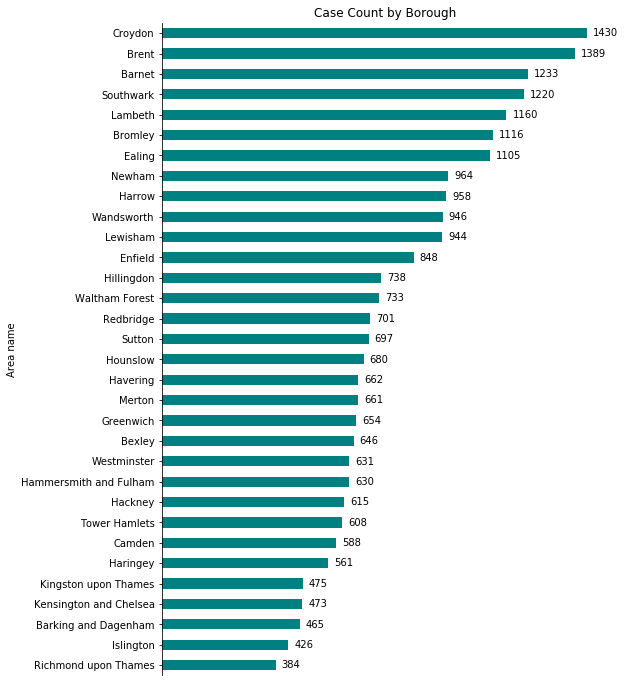

In [19]:
%matplotlib inline
ax = cv_data.sort_values("Cumulative lab-confirmed cases",ascending=True).plot.barh(x="Area name",
                                                                               y="Cumulative lab-confirmed cases",
                                                                               color="#008080",
                                                                               figsize=(8,12),
                                                                               title="Case Count by Borough")
    
ax.get_xaxis().set_visible(False)
ax.get_legend().set_visible(False)

# display percentages
for p in ax.patches:
    ax.annotate("{}".format(p.get_width()),
                xy=(p.get_width()+20, p.get_y()+0.1));
    
# remove borders
for s in ['top','right','bottom']:
    ax.spines[s].set_visible(False);

Check there are no missing boroughs.

In [20]:
print(boro_data.shape)
print(cv_data.shape)

(32, 87)
(32, 6)


Also normalise cases by borough and plot.

In [21]:
df = pd.DataFrame()
df["Area name"] = cv_data["Area name"]
df.reset_index(drop=True,inplace=True)
A = cv_data.sort_values("Area name").reset_index(drop=True)["Cumulative lab-confirmed cases"]
B = boro_data.sort_values("Area name").reset_index(drop=True)["GLA Population Estimate 2017"]
df["Prevalence rate"] = A/B*1000
#df["Prevalence rate"] = cv_data.sort_values("Area name").reset_index(drop=True)["Cumulative lab-confirmed cases"].divide(boro_data.sort_values("Area name").reset_index(drop=True)["GLA Population Estimate 2017"])
#cv_data.sort_values("Area name").reset_index(drop=True)["Cumulative lab-confirmed cases"]
#boro_data.sort_values("Area name").reset_index(drop=True)["GLA Population Estimate 2017"]
df

,Area name,Prevalence rate
0,Westminster,2.224880
1,Wandsworth,3.164784
2,Waltham Forest,2.644290
3,Tower Hamlets,4.182475
4,Sutton,3.403477
5,Southwark,2.424742
6,Richmond upon Thames,3.699871
7,Redbridge,3.142776
8,Newham,2.546547
9,Merton,2.334880


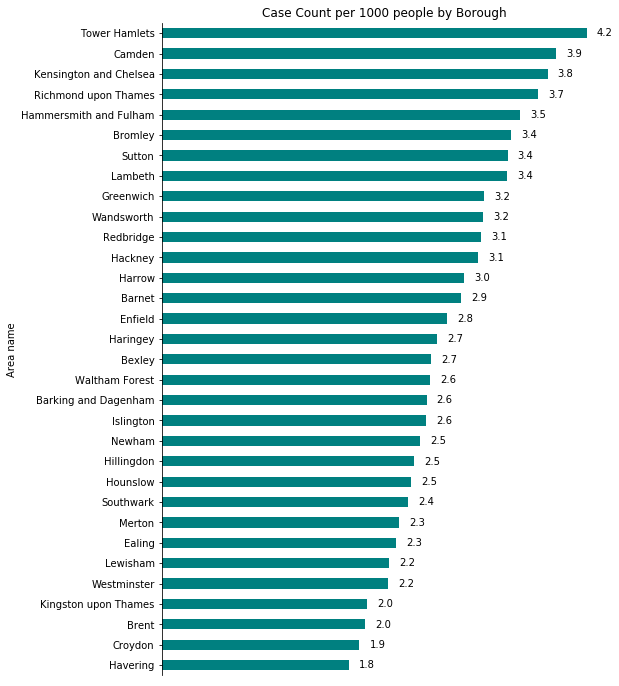

In [22]:
ax = df.sort_values("Prevalence rate",ascending=True).plot.barh(x="Area name",
                                                                y="Prevalence rate",
                                                                color="#008080",
                                                                figsize=(8,12),
                                                                title="Case Count per 1000 people by Borough")
    
ax.get_xaxis().set_visible(False)
ax.get_legend().set_visible(False)

# display percentages
for p in ax.patches:
    ax.annotate("{:.2}".format(p.get_width()),
                xy=(p.get_width()+0.1, p.get_y()+0.1));
    
# remove borders
for s in ['top','right','bottom']:
    ax.spines[s].set_visible(False);


In [23]:
print(df["Prevalence rate"].mean())
print(df["Prevalence rate"].std())

2.8341277550513655
0.6120244207819974


### 2.3 Download Foursquare Data

Set up Foursquare credentials and version. N.B. date set to 1st March to get popular venues immediately prior to the mass outbreak.

In [24]:
CLIENT_ID = "FHTCPMSOA2VMEKJJGQADH5O2HMWAMQOK0WXIK5WBH5MS4KSW"
CLIENT_SECRET = "BH0M3X0BJYIDTR24MZYMNNVUJ4Y5MCNYZTU2J2I3MFLRL5DQ"
VERSION = '20200301' # Date set prior to the mass outbreak of coronavirus

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: FHTCPMSOA2VMEKJJGQADH5O2HMWAMQOK0WXIK5WBH5MS4KSW
CLIENT_SECRET:BH0M3X0BJYIDTR24MZYMNNVUJ4Y5MCNYZTU2J2I3MFLRL5DQ


#### Get nearby venues for each borough.

In [25]:
LIMIT = 200
radius = 1500

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area name', 
                  'Area Latitude', 
                  'Area Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

venues_data = getNearbyVenues(names=boro_data['Area name'],
                              latitudes=boro_data['Latitude'],
                              longitudes=boro_data['Longitude'])

Barking and Dagenham
Barnet
Bexley
Brent
Bromley
Camden
Croydon
Ealing
Enfield
Greenwich
Hackney
Hammersmith and Fulham
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston upon Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Richmond upon Thames
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster


#### Check data size and shape.

In [26]:
print(venues_data.shape)
venues_data.head()

(1212, 7)


,Area name,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Barking and Dagenham,51.554117,0.150504,Tesco Express,51.551536,0.152784,Grocery Store
1,Barking and Dagenham,51.554117,0.150504,Connor Road Bus Stop,51.554345,0.147162,Bus Stop
2,Barking and Dagenham,51.554117,0.150504,Oglethorpe Road Bus Stop,51.555221,0.147136,Bus Stop
3,Barking and Dagenham,51.554117,0.150504,Five Elms Off Licence,51.553878,0.145531,Liquor Store
4,Barking and Dagenham,51.554117,0.150504,Post office,51.551411,0.155003,Convenience Store


#### Group by borough.

In [27]:
venues_data.groupby('Area name').count()

,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Area name,,,,,,
Barking and Dagenham,5,5,5,5,5,5
Barnet,32,32,32,32,32,32
Bexley,11,11,11,11,11,11
Brent,17,17,17,17,17,17
Bromley,46,46,46,46,46,46
Camden,86,86,86,86,86,86
Croydon,25,25,25,25,25,25
Ealing,94,94,94,94,94,94
Enfield,62,62,62,62,62,62


#### Determine Unique Categories.

In [28]:
print('There are {} uniques categories.'.format(len(venues_data['Venue Category'].unique())))

There are 214 uniques categories.


#### Create One-Hot Encoding of Venue Data.

In [29]:
# one hot encoding
venues_onehot = pd.get_dummies(venues_data[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_onehot['Area name'] = venues_data['Area name'] 

# move neighborhood column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

venues_onehot.head()

,Area name,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Austrian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beach,Beer Bar,Beer Store,Bistro,Boarding House,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Canal,Canal Lock,Candy Store,Caribbean Restaurant,Chaat Place,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Liquor Store,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Restaurant,Road,Rock Club,Romanian Restaurant,Salad Place,Sandwich Place,Scenic Lookout,Sculpture Garden,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Smoothie Shop,Snack Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Train Station,Tram Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [30]:
venues_onehot.shape

(1212, 215)

#### Group boroughs by neighborhood and take the mean occurence of each category.

In [31]:
venues_grouped = venues_onehot.groupby('Area name').mean().reset_index()
venues_grouped

,Area name,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Austrian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beach,Beer Bar,Beer Store,Bistro,Boarding House,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Canal,Canal Lock,Candy Store,Caribbean Restaurant,Chaat Place,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Liquor Store,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Restaurant,Road,Rock Club,Romanian Restaurant,Salad Place,Sandwich Place,Scenic Lookout,Sculpture Garden,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Smoothie Shop,Snack Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Train Station,Tram Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Barking and Dagenham,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [32]:
venues_grouped.shape

(32, 215)

#### Print top 5 most common venues in each borough.

In [33]:
num_top_venues = 5

for hood in venues_grouped['Area name']:
    print("----"+hood+"----")
    temp = venues_grouped[venues_grouped['Area name'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Barking and Dagenham----
               venue  freq
0           Bus Stop   0.4
1      Grocery Store   0.2
2  Convenience Store   0.2
3       Liquor Store   0.2
4  Afghan Restaurant   0.0


----Barnet----
                venue  freq
0         Coffee Shop  0.12
1  Italian Restaurant  0.09
2                 Pub  0.06
3       Grocery Store  0.06
4           Bookstore  0.06


----Bexley----
                  venue  freq
0                   Pub  0.18
1  Fast Food Restaurant  0.18
2        Breakfast Spot  0.09
3     Indian Restaurant  0.09
4    Italian Restaurant  0.09


----Brent----
               venue  freq
0        Coffee Shop  0.18
1  Indian Restaurant  0.12
2        Supermarket  0.12
3              Hotel  0.12
4   Pedestrian Plaza  0.06


----Bromley----
                  venue  freq
0        Clothing Store  0.13
1           Coffee Shop  0.09
2  Gym / Fitness Center  0.07
3                   Pub  0.04
4          Burger Joint  0.04


----Camden----
          venue  freq
0           

#### Store top 10 within a new dataframe.

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Area name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Area name'] = venues_grouped['Area name']

for ind in np.arange(venues_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

venues_sorted.head()

,Area name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Bus Stop,Convenience Store,Liquor Store,Grocery Store,Yoga Studio,Farm,Food Court,Food & Drink Shop,Food,Flea Market
1,Barnet,Coffee Shop,Italian Restaurant,Convenience Store,Park,Pub,Restaurant,Bookstore,Pharmacy,Grocery Store,Indian Restaurant
2,Bexley,Fast Food Restaurant,Pub,Greek Restaurant,Breakfast Spot,Toy / Game Store,Train Station,Italian Restaurant,Chinese Restaurant,Indian Restaurant,Fish & Chips Shop
3,Brent,Coffee Shop,Hotel,Supermarket,Indian Restaurant,Burger Joint,Sports Bar,Café,Fast Food Restaurant,Sandwich Place,Electronics Store
4,Bromley,Clothing Store,Coffee Shop,Gym / Fitness Center,Burger Joint,Pub,Portuguese Restaurant,Pizza Place,Bookstore,Stationery Store,Furniture / Home Store


### 2.4 Combine Sources

Blah blah blah, all going to be combined into one dataframe.
#### Refresh memory on borough data

In [35]:
boro_data.head()

,Area name,Code,New code,Inner/ Outer London,GLA Population Estimate 2017,GLA Household Estimate 2017,Inland Area (Hectares),Population density (per hectare) 2017,"Average Age, 2017","Proportion of population aged 0-15, 2015","Proportion of population of working-age, 2015","Proportion of population aged 65 and over, 2015",Net internal migration (2015),Net international migration (2015),Net natural change (2015),% of resident population born abroad (2015),Largest migrant population by country of birth (2011),% of largest migrant population (2011),Second largest migrant population by country of birth (2011),% of second largest migrant population (2011),Third largest migrant population by country of birth (2011),% of third largest migrant population (2011),% of population from BAME groups (2016),% people aged 3+ whose main language is not English (2011 Census),"Overseas nationals entering the UK (NINo), (2015/16)","New migrant (NINo) rates, (2015/16)",Largest migrant population arrived during 2015/16,Second largest migrant population arrived during 2015/16,Third largest migrant population arrived during 2015/16,Employment rate (%) (2015),Male employment rate (2015),Female employment rate (2015),Unemployment rate (2015),Youth Unemployment (claimant) rate 18-24 (Dec-15),Proportion of 16-18 year olds who are NEET (%) (2014),Proportion of the working-age population who claim out-of-work benefits (%) (May-2016),% working-age with a disability (2015),Proportion of working age people with no qualifications (%) 2015,Proportion of working age with degree or equivalent and above (%) 2015,"Gross Annual Pay, (2016)",Gross Annual Pay - Male (2016),Gross Annual Pay - Female (2016),Modelled Household median income estimates 2012/13,% adults that volunteered in past 12 months (2010/11 to 2012/13),Number of jobs by workplace (2014),% of employment that is in public sector (2014),"Jobs Density, 2015","Number of active businesses, 2015",Two-year business survival rates (started in 2013),Crime rates per thousand population 2014/15,Fires per thousand population (2014),Ambulance incidents per hundred population (2014),"Median House Price, 2015","Average Band D Council Tax charge (£), 2015/16",New Homes (net) 2015/16 (provisional),"Homes Owned outright, (2014) %","Being bought with mortgage or loan, (2014) %","Rented from Local Authority or Housing Association, (2014) %","Rented from Private landlord, (2014) %","% of area that is Greenspace, 2005",Total carbon emissions (2014),"Household Waste Recycling Rate, 2014/15","Number of cars, (2011 Census)","Number of cars per household, (2011 Census)","% of adults who cycle at least once per month, 2014/15","Average Public Transport Accessibility score, 2014","Achievement of 5 or more A*- C grades at GCSE or equivalent including English and Maths, 2013/14",Rates of Children Looked After (2016),% of pupils whose first language is not English (2015),% children living in out-of-work households (2015),"Male life expectancy, (2012-14)","Female life expectancy, (2012-14)",Teenage conception rate (2014),Life satisfaction score 2011-14 (out of 10),Worthwhileness score 2011-14 (out of 10),Happiness score 2011-14 (out of 10),Anxiety score 2011-14 (out of 10),Childhood Obesity Prevalance (%) 2015/16,People aged 17+ with diabetes (%),Mortality rate from causes considered preventable 2012/14,Political control in council,Proportion of seats won by Conservatives in 2014 election,Proportion of seats won by Labour in 2014 election,Proportion of seats won by Lib Dems in 2014 election,Turnout at 2014 local elections,Latitude,Longitude
0,Barking and Dagenham,E09000002,E09000002,Outer London,209000.0,78188.4,3610.78,57.8822,32.9,27.2,63.1,9.7,-1176,2509,2356,37.8,Nigeria,4.67697,India,2.34736,Pakistan,2.33284,49.5318,18.7242,7538.0,59.139658,Romania,Bulgaria,Lithuania,65.8,75.6,56.5,11,4.49666,5.7,10.5287,17.2,11.3,32.2,27886,30104,24602,29420,20.5297,58900,21.104536,0.48,6560.0,73.0,83.3591,3.03015,13.6693,243500,1354.03,730,16.

#### Trim borough data and convert Inner/Outer London to boolean

In [36]:
london_data = boro_data[["Area name",
           "Population density (per hectare) 2017",
           "Average Age, 2017",
           'Proportion of population aged 0-15, 2015',
           'Proportion of population of working-age, 2015',
           'Proportion of population aged 65 and over, 2015',
           '% of resident population born abroad (2015)',
           '% of population from BAME groups (2016)',
           '% people aged 3+ whose main language is not English (2011 Census)',
           'New migrant (NINo) rates, (2015/16)',
           'Employment rate (%) (2015)',
           'Unemployment rate (2015)',
           'Youth Unemployment (claimant) rate 18-24 (Dec-15)',
           'Proportion of the working-age population who claim out-of-work benefits (%) (May-2016)',
           '% working-age with a disability (2015)',
           'Proportion of working age people with no qualifications (%) 2015',
           'Proportion of working age with degree or equivalent and above (%) 2015',
           'Gross Annual Pay, (2016)',
           'Modelled Household median income estimates 2012/13',
           'Jobs Density, 2015',
           'Homes Owned outright, (2014) %',
           '% of area that is Greenspace, 2005',
           '% of adults who cycle at least once per month, 2014/15',
           'Male life expectancy, (2012-14)',
           'Female life expectancy, (2012-14)',
           'Life satisfaction score 2011-14 (out of 10)',
           'Worthwhileness score 2011-14 (out of 10)',
           'Happiness score 2011-14 (out of 10)',
           'Anxiety score 2011-14 (out of 10)',
           'Childhood Obesity Prevalance (%) 2015/16',
           'People aged 17+ with diabetes (%)'
          ]]

in_out_onehot = pd.get_dummies(boro_data["Inner/ Outer London"],prefix="",prefix_sep="")
in_out_onehot.drop(columns=["Outer London"],inplace=True)
in_out_onehot["Area name"] = boro_data["Area name"]

london_data = london_data.set_index("Area name").join(in_out_onehot.set_index("Area name"))
demographics_data = london_data.reset_index()
# london_data.reset_index(inplace=True)
london_data.reset_index().head()

,Area name,Population density (per hectare) 2017,"Average Age, 2017","Proportion of population aged 0-15, 2015","Proportion of population of working-age, 2015","Proportion of population aged 65 and over, 2015",% of resident population born abroad (2015),% of population from BAME groups (2016),% people aged 3+ whose main language is not English (2011 Census),"New migrant (NINo) rates, (2015/16)",Employment rate (%) (2015),Unemployment rate (2015),Youth Unemployment (claimant) rate 18-24 (Dec-15),Proportion of the working-age population who claim out-of-work benefits (%) (May-2016),% working-age with a disability (2015),Proportion of working age people with no qualifications (%) 2015,Proportion of working age with degree or equivalent and above (%) 2015,"Gross Annual Pay, (2016)",Modelled Household median income estimates 2012/13,"Jobs Density, 2015","Homes Owned outright, (2014) %","% of area that is Greenspace, 2005","% of adults who cycle at least once per month, 2014/15","Male life expectancy, (2012-14)","Female life expectancy, (2012-14)",Life satisfaction score 2011-14 (out of 10),Worthwhileness score 2011-14 (out of 10),Happiness score 2011-14 (out of 10),Anxiety score 2011-14 (out of 10),Childhood Obesity Prevalance (%) 2015/16,People aged 17+ with diabetes (%),Inner London
0,Barking and Dagenham,57.8822,32.9,27.2,63.1,9.7,37.8,49.5318,18.7242,59.139658,65.8,11,4.49666,10.5287,17.2,11.3,32.2,27886,29420,0.48,16.4379,33.6,8.78045,77.6,82.1,7.14,7.60,7.05,3.05,28.542,7.272108,0
1,Barnet,44.9115,37.3,21.1,64.9,14.0,35.2,38.6637,23.405,53.113642,68.5,8.5,1.93749,6.20214,14.9,5.2,49,33443,40530,0.67,32.3901,41.3,7.36457,82.1,85.1,7.48,7.76,7.37,2.75,20.6579,6.026084,0
2,Bexley,40.3264,39.0,20.6,62.9,16.6,16.1,21.4063,6.03129,14.433558,75.1,7.6,2.85371,6.77681,15.9,10.8,33.5,34350,36990,0.56,38.0855,31.7,10.557,80.4,84.4,7.38,7.70,7.21,3.29,22.7093,6.859383,0
3,Brent,76.817,35.6,20.9,67.8,11.3,53.9,64.8563,37.1511,100.890910,69.5,7.5,3.07824,8.2581,17.7,6.2,45.1,29812,32140,0.61,22.2307,21.9,7.87387,80.1,85.1,7.25,7.35,7.22,2.92,24.3444,7.920348,0
4,Bromley,21.8404,40.2,19.9,62.6,17.5,18.3,18.9481,5.79282,14.370245,75.3,5.3,2.53807,6.01054,15.9,4.3,46.7,37682,43060,0.60,37.7709,57.8,12.9768,81.4,84.9,7.54,7.86,7.44,3.26,15.9988,5.242389,0


In [39]:
london_data.shape

(32, 34)

#### Join Covid-19 data to dataframe

In [37]:
london_data = london_data.join(cv_data[["Area name","Cumulative lab-confirmed cases"]].set_index("Area name"))
london_data.reset_index().head()

,Area name,Population density (per hectare) 2017,"Average Age, 2017","Proportion of population aged 0-15, 2015","Proportion of population of working-age, 2015","Proportion of population aged 65 and over, 2015",% of resident population born abroad (2015),% of population from BAME groups (2016),% people aged 3+ whose main language is not English (2011 Census),"New migrant (NINo) rates, (2015/16)",Employment rate (%) (2015),Unemployment rate (2015),Youth Unemployment (claimant) rate 18-24 (Dec-15),Proportion of the working-age population who claim out-of-work benefits (%) (May-2016),% working-age with a disability (2015),Proportion of working age people with no qualifications (%) 2015,Proportion of working age with degree or equivalent and above (%) 2015,"Gross Annual Pay, (2016)",Modelled Household median income estimates 2012/13,"Jobs Density, 2015","Homes Owned outright, (2014) %","% of area that is Greenspace, 2005","% of adults who cycle at least once per month, 2014/15","Male life expectancy, (2012-14)","Female life expectancy, (2012-14)",Life satisfaction score 2011-14 (out of 10),Worthwhileness score 2011-14 (out of 10),Happiness score 2011-14 (out of 10),Anxiety score 2011-14 (out of 10),Childhood Obesity Prevalance (%) 2015/16,People aged 17+ with diabetes (%),Inner London,Cumulative lab-confirmed cases
0,Barking and Dagenham,57.8822,32.9,27.2,63.1,9.7,37.8,49.5318,18.7242,59.139658,65.8,11,4.49666,10.5287,17.2,11.3,32.2,27886,29420,0.48,16.4379,33.6,8.78045,77.6,82.1,7.14,7.60,7.05,3.05,28.542,7.272108,0,465
1,Barnet,44.9115,37.3,21.1,64.9,14.0,35.2,38.6637,23.405,53.113642,68.5,8.5,1.93749,6.20214,14.9,5.2,49,33443,40530,0.67,32.3901,41.3,7.36457,82.1,85.1,7.48,7.76,7.37,2.75,20.6579,6.026084,0,1233
2,Bexley,40.3264,39.0,20.6,62.9,16.6,16.1,21.4063,6.03129,14.433558,75.1,7.6,2.85371,6.77681,15.9,10.8,33.5,34350,36990,0.56,38.0855,31.7,10.557,80.4,84.4,7.38,7.70,7.21,3.29,22.7093,6.859383,0,646
3,Brent,76.817,35.6,20.9,67.8,11.3,53.9,64.8563,37.1511,100.890910,69.5,7.5,3.07824,8.2581,17.7,6.2,45.1,29812,32140,0.61,22.2307,21.9,7.87387,80.1,85.1,7.25,7.35,7.22,2.92,24.3444,7.920348,0,1389
4,Bromley,21.8404,40.2,19.9,62.6,17.5,18.3,18.9481,5.79282,14.370245,75.3,5.3,2.53807,6.01054,15.9,4.3,46.7,37682,43060,0.60,37.7709,57.8,12.9768,81.4,84.9,7.54,7.86,7.44,3.26,15.9988,5.242389,0,1116


In [38]:
# london_data.drop(columns=["Prevalence rate"]) =
london_data.reset_index(inplace=True)
london_data["Prevalence rate"]=london_data["Cumulative lab-confirmed cases"].divide(boro_data["GLA Population Estimate 2017"])

In [40]:
london_data.shape

(32, 34)

#### Join venues data to dataframe

In [41]:
london_data = london_data.set_index("Area name").join(venues_grouped.set_index("Area name"))
london_data.reset_index(inplace=True)
london_data.head()

,Area name,Population density (per hectare) 2017,"Average Age, 2017","Proportion of population aged 0-15, 2015","Proportion of population of working-age, 2015","Proportion of population aged 65 and over, 2015",% of resident population born abroad (2015),% of population from BAME groups (2016),% people aged 3+ whose main language is not English (2011 Census),"New migrant (NINo) rates, (2015/16)",Employment rate (%) (2015),Unemployment rate (2015),Youth Unemployment (claimant) rate 18-24 (Dec-15),Proportion of the working-age population who claim out-of-work benefits (%) (May-2016),% working-age with a disability (2015),Proportion of working age people with no qualifications (%) 2015,Proportion of working age with degree or equivalent and above (%) 2015,"Gross Annual Pay, (2016)",Modelled Household median income estimates 2012/13,"Jobs Density, 2015","Homes Owned outright, (2014) %","% of area that is Greenspace, 2005","% of adults who cycle at least once per month, 2014/15","Male life expectancy, (2012-14)","Female life expectancy, (2012-14)",Life satisfaction score 2011-14 (out of 10),Worthwhileness score 2011-14 (out of 10),Happiness score 2011-14 (out of 10),Anxiety score 2011-14 (out of 10),Childhood Obesity Prevalance (%) 2015/16,People aged 17+ with diabetes (%),Inner London,Cumulative lab-confirmed cases,Prevalence rate,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Austrian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beach,Beer Bar,Beer Store,Bistro,Boarding House,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Canal,Canal Lock,Candy Store,Caribbean Restaurant,Chaat Place,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Liquor Store,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Restaurant,Road,Rock Club,Romanian Restaurant,Salad Place,Sandwich Place,Scenic Lookout,Sculpture Garden,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Smoothie Shop,Snack Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sp

#### RBKC information is missing, infer value from household median income estimates.

In [42]:
av_gp = london_data["Gross Annual Pay, (2016)"][london_data["Gross Annual Pay, (2016)"]!="."].astype(float).mean()
av_mi = london_data["Modelled Household median income estimates 2012/13"][london_data["Modelled Household median income estimates 2012/13"]!="."].astype(float).mean()
r = london_data.loc[18,"Modelled Household median income estimates 2012/13"]/av_mi
london_data.loc[18,"Gross Annual Pay, (2016)"] = r*av_gp
demographics_data.loc[18,"Gross Annual Pay, (2016)"] = r*av_gp

## 3. Modelling

### 3.1 Study 1: Clustering based on Demography

#### First, pre-process demographics data with the standard scaler.

In [43]:
X1 = demographics_data.values[:,1:].astype(float)
X1 = StandardScaler().fit_transform(X1)
X1

array([[-4.65895908e-01, -1.50670843e+00,  3.04795189e+00,
        -1.31183729e+00, -6.48122020e-01,  1.24633144e-01,
         5.99855480e-01, -3.45317179e-01,  2.88286681e-01,
        -1.81033090e+00,  2.65520890e+00,  9.06135102e-01,
         1.68638376e+00,  5.41971705e-01,  1.57634658e+00,
        -1.65419525e+00, -1.52223127e+00, -1.57543787e+00,
        -5.91078420e-01, -6.93374984e-01,  1.15541724e-01,
        -9.42612877e-01, -1.90797046e+00, -1.87263729e+00,
        -1.12249722e+00,  2.23065282e-01, -1.57626262e+00,
        -8.63561887e-01,  1.58773425e+00,  1.09715986e+00,
        -8.27170192e-01],
       [-8.02072270e-01,  5.25327460e-01,  3.82359556e-01,
        -8.39870843e-01,  7.69709299e-01, -1.27053205e-01,
        -1.78268475e-01,  1.85399224e-01,  3.42416045e-02,
        -1.12849747e+00,  1.30653136e+00, -1.48249727e+00,
        -8.13563075e-01, -4.65329242e-01, -7.65379847e-01,
        -9.86672343e-02, -2.66117141e-01,  2.72283146e-01,
        -3.27606514e-01,  1.24

#### Find elbow point when using k-means clustering, determined to be at 7 clusters.

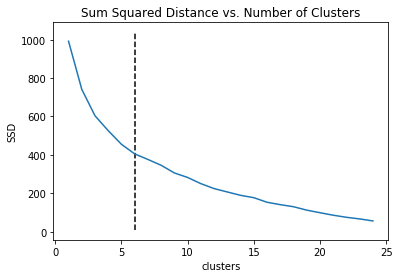

In [44]:
sum_squared_dist = []
K = range(1,25)
for k in K:
    km = KMeans(init="k-means++",n_clusters=k,n_init = 12,random_state=0)
    km = km.fit(X1)
    sum_squared_dist.append(km.inertia_)

%matplotlib inline

fig, ax = plt.subplots()
ax.plot(K, sum_squared_dist)
ax.set(xlabel='clusters', ylabel='SSD',
       title='Sum Squared Distance vs. Number of Clusters')
plt.vlines(6, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

In [45]:
kclusters=6
km = KMeans(init = "k-means++", n_clusters = kclusters, n_init = 12)
km.fit(X1)
labels1 = km.labels_
demographics_data = demographics_data.join(pd.DataFrame({"Cluster Labels":labels1}))
demographics_data

,Area name,Population density (per hectare) 2017,"Average Age, 2017","Proportion of population aged 0-15, 2015","Proportion of population of working-age, 2015","Proportion of population aged 65 and over, 2015",% of resident population born abroad (2015),% of population from BAME groups (2016),% people aged 3+ whose main language is not English (2011 Census),"New migrant (NINo) rates, (2015/16)",Employment rate (%) (2015),Unemployment rate (2015),Youth Unemployment (claimant) rate 18-24 (Dec-15),Proportion of the working-age population who claim out-of-work benefits (%) (May-2016),% working-age with a disability (2015),Proportion of working age people with no qualifications (%) 2015,Proportion of working age with degree or equivalent and above (%) 2015,"Gross Annual Pay, (2016)",Modelled Household median income estimates 2012/13,"Jobs Density, 2015","Homes Owned outright, (2014) %","% of area that is Greenspace, 2005","% of adults who cycle at least once per month, 2014/15","Male life expectancy, (2012-14)","Female life expectancy, (2012-14)",Life satisfaction score 2011-14 (out of 10),Worthwhileness score 2011-14 (out of 10),Happiness score 2011-14 (out of 10),Anxiety score 2011-14 (out of 10),Childhood Obesity Prevalance (%) 2015/16,People aged 17+ with diabetes (%),Inner London,Cluster Labels
0,Barking and Dagenham,57.8822,32.9,27.2,63.1,9.7,37.8,49.5318,18.7242,59.139658,65.8,11,4.49666,10.5287,17.2,11.3,32.2,27886,29420,0.48,16.4379,33.6,8.78045,77.6,82.1,7.14,7.60,7.05,3.05,28.542,7.272108,0,5
1,Barnet,44.9115,37.3,21.1,64.9,14.0,35.2,38.6637,23.405,53.113642,68.5,8.5,1.93749,6.20214,14.9,5.2,49,33443,40530,0.67,32.3901,41.3,7.36457,82.1,85.1,7.48,7.76,7.37,2.75,20.6579,6.026084,0,3
2,Bexley,40.3264,39.0,20.6,62.9,16.6,16.1,21.4063,6.03129,14.433558,75.1,7.6,2.85371,6.77681,15.9,10.8,33.5,34350,36990,0.56,38.0855,31.7,10.557,80.4,84.4,7.38,7.70,7.21,3.29,22.7093,6.859383,0,1
3,Brent,76.817,35.6,20.9,67.8,11.3,53.9,64.8563,37.1511,100.890910,69.5,7.5,3.07824,8.2581,17.7,6.2,45.1,29812,32140,0.61,22.2307,21.9,7.87387,80.1,85.1,7.25,7.35,7.22,2.92,24.3444,7.920348,0,5
4,Bromley,21.8404,40.2,19.9,62.6,17.5,18.3,18.9481,5.79282,14.370245,75.3,5.3,2.53807,6.01054,15.9,4.3,46.7,37682,43060,0.60,37.7709,57.8,12.9768,81.4,84.9,7.54,7.86,7.44,3.26,15.9988,5.242389,0,1
5,Camden,111.293,36.4,17.3,71.0,11.7,41.4,34.5934,23.4633,60.697105,69.2,4,3.63115,8.52822,21.3,6.1,61.1,39796,43750,2.23,18.5422,24.8,18.8181,81.8,86.7,7.14,7.38,7.11,3.61,21.3267,3.858989,1,2
6,Croydon,44.6802,37.0,22.0,64.9,13.0,29.4,49.9179,14.4953,32.283752,75.4,4.1,4.80365,7.78044,17.5,7,40.6,32696,37000,0.58,30.77,37.1,12.7604,80.3,83.6,7.10,7.57,7.18,3.30,24.4814,6.483704,0,3
7,Ealing,63.3008,36.2,21.4,66.8,11.8,47.4,53.4547,33.8785,65.151826,72.7,5.8,2.95563,7.89574,15.2,9.1,49.7,31331,36070,0.71,20.1181,30.9,15.0358,80.6,84.2,7.29,7.57,7.26,3.57,23.8228,6.919389,0,3
8,Enfield,41.1966,36.3,22.8,64.4,12.8,35,42.2884,22.8532,43.757709,73.0,3.8,3.34031,9.25817,18.4,4.5,43.4,31603,33110,0.62,25.5977,45.6,7.88272,80.7,84.1,7.26,7.57,7.33,2.60,25.1879,7.042382,0,3
9,Greenwich,59.1754,35.0,21.9,67.7,10.4,35.4,40.3156,16.864,37.630392,72.1,8.1,5.35714,9.46403,20.2,10.6,42.2,32415,35350,0.51,19.2422,34.4,7.68348,79,82.5,7.20,7.55,7.20,3.40,27.7255,6.131174,0,5


#### Now visualise resulting clusters

In [46]:
address = 'London,UK'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of London using latitude and longitude values
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(boro_data['Latitude'], boro_data['Longitude'], boro_data['Area name'], demographics_data['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examine average makeup of the clusters to understand the demographic.

In [47]:
temp = demographics_data.set_index("Area name")
clustered_demographics_data = temp.astype(float,errors="ignore").groupby("Cluster Labels").mean()
clustered_demographics_data

,Population density (per hectare) 2017,"Average Age, 2017","Proportion of population aged 0-15, 2015","Proportion of population of working-age, 2015","Proportion of population aged 65 and over, 2015",% of resident population born abroad (2015),% of population from BAME groups (2016),% people aged 3+ whose main language is not English (2011 Census),"New migrant (NINo) rates, (2015/16)",Employment rate (%) (2015),Unemployment rate (2015),Youth Unemployment (claimant) rate 18-24 (Dec-15),Proportion of the working-age population who claim out-of-work benefits (%) (May-2016),% working-age with a disability (2015),Proportion of working age people with no qualifications (%) 2015,Proportion of working age with degree or equivalent and above (%) 2015,"Gross Annual Pay, (2016)",Modelled Household median income estimates 2012/13,"Jobs Density, 2015","Homes Owned outright, (2014) %","% of area that is Greenspace, 2005","% of adults who cycle at least once per month, 2014/15","Male life expectancy, (2012-14)","Female life expectancy, (2012-14)",Life satisfaction score 2011-14 (out of 10),Worthwhileness score 2011-14 (out of 10),Happiness score 2011-14 (out of 10),Anxiety score 2011-14 (out of 10),Childhood Obesity Prevalance (%) 2015/16,People aged 17+ with diabetes (%),Inner London
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,128.531816,33.866667,18.916667,73.250000,7.833333,36.083333,44.057409,22.411806,53.198003,73.433333,6.483333,4.545031,9.508307,16.216667,7.766667,55.450000,34256.500000,36891.666667,0.988333,11.830935,19.250000,20.189339,78.733333,83.316667,7.201667,7.480000,7.170000,3.516667,25.178789,5.655974,1.000000
1.0,32.751898,39.600000,20.125000,63.025000,16.900000,17.100000,20.274903,6.602876,15.481840,76.275000,5.925000,2.733903,6.234959,16.100000,7.475000,37.175000,34531.750000,39165.000000,0.595000,34.179024,45.200000,10.191091,80.725000,84.150000,7.442500,7.727500,7.280000,3.262500,19.718946,5.966541,0.000000
2.0,111.983033,37.050000,16.600000,71.650000,11.700000,45.600000,36.692254,27.146053,66.328744,67.400000,6.400000,3.544030,8.075222,19.400000,5.300000,62.350000,40968.500000,45630.000000,3.265000,17.835092,31.500000,17.285962,82.050000,86.500000,7.195000,7.415000,7.120000,3.520000,23.134470,4.106297,1.000000
3.0,46.625416,36.637500,21.625000,65.462500,12.900000,39.437500,50.761887,24.398646,51.564605,72.400000,5.600000,3.115662,6.886254,16.562500,6.925000,45.125000,32533.375000,36852.500000,0.706250,27.447708,39.862500,11.422717,80.962500,84.437500,7.307500,7.595000,7.303750,3.123750,22.851219,6.960414,0.000000
4.0,79.097527,37.100000,18.750000,68.883333,12.350000,36.466667,29.361251,19.332632,46.295701,76.216667,4.583333,2.743896,6.048915,13.033333,4.700000,63.383333,40333.723326,47715.000000,0.915000,23.315178,30.483333,22.611038,81.216667,84.833333,7.425000,7.655000,7.326667,3.305000,17.989691,4.484839,0.500000
5.0,75.616254,34.300000,22.416667,67.900000,9.666667,43.000000,52.637355,28.379269,78.263601,69.666667,7.800000,4.357361,9.000150,16.600000,9.916667,42.450000,29996.166667,32365.000000,0.503333,17.641403,28.450000,9.479269,79.116667,83.566667,7.190000,7.488333,7.160000,3.176667,26.385854,6.879054,0.333333


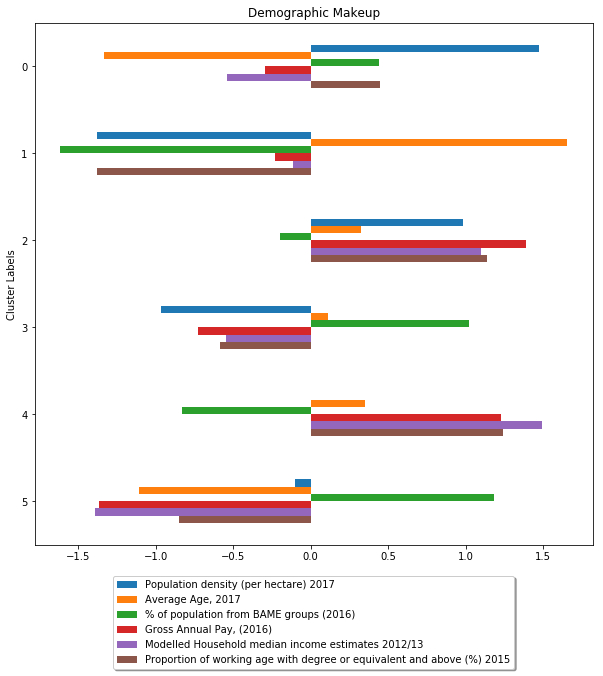

In [49]:
scaled_clusters = pd.DataFrame(StandardScaler().fit_transform(clustered_demographics_data),
                               columns=clustered_demographics_data.columns,
                               index=clustered_demographics_data.index.astype(int))
ax = scaled_clusters.reset_index().plot.barh(x="Cluster Labels",
                         y=['Population density (per hectare) 2017',
                            'Average Age, 2017',
                            '% of population from BAME groups (2016)',
                            'Gross Annual Pay, (2016)',
                            'Modelled Household median income estimates 2012/13',
                            'Proportion of working age with degree or equivalent and above (%) 2015'],                           
                        figsize=(10,16),
                        title="Demographic Makeup")
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height,
                 box.width, box.height * 0.6])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True)
plt.gca().invert_yaxis()
plt.show()

General features of each cluster:

- Cluster 0: High-density, inner-city boroughs. Populations are of average age, affluence, and education with average numbers of BAME groups.

- Cluster 1: Low-density, outer-city boroughs. Populations are older and less educated with average affluence and low numbers of BAME groups.

- Cluster 2: High-density, inner-city boroughs. Populations are of average age, more affluent, and more educated with average numbers of BAME groups. 

- Cluster 3: Low-density, outer-city boroughs. Populations are older, of average affluence and less education, with low numbers of BAME groups 

- Cluster 4: Mix of high- and low- density inner- and outer- city boroughs. Populations are of average age, more affluence, and more education with low numbers of BAME groups.

- Cluster 5: Mostly outer city boroughs of average density. Populations are younger, less affluent, and less educated with high numbers of BAME groups.

#### Plot each cluster's prevalence of Covid-19

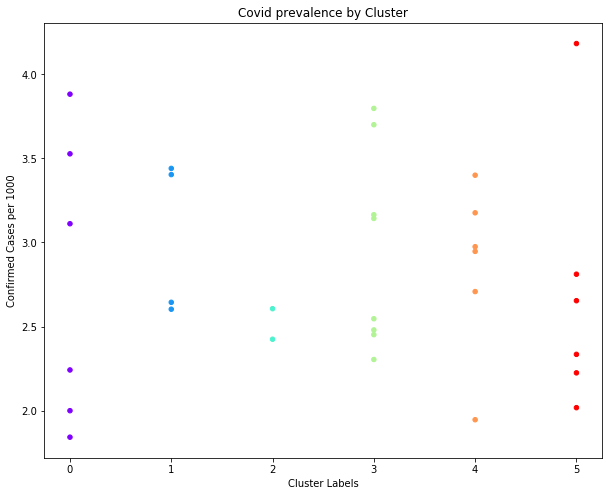

In [50]:
cv_by_demographics_clusters = demographics_data[["Area name","Cluster Labels"]].set_index(["Area name"]).join(london_data[["Area name","Prevalence rate"]].set_index(["Area name"])).reset_index()
cv_by_demographics_clusters["Confirmed Cases per 1000"] = cv_by_demographics_clusters["Prevalence rate"]*1000 # cases per 1000 people

color_sequence = []
for i in cv_by_demographics_clusters["Cluster Labels"]:
    color_sequence.append(rainbow[i])
    
ax = cv_by_demographics_clusters.plot.scatter(x="Cluster Labels",
                                        y="Confirmed Cases per 1000",
                                        c=color_sequence,
                                        figsize=(10,8),
                                        title="Covid prevalence by Cluster")

#### Conclusion, no apparent effect of demographics on the spread of coronavirus within a borough.

### 3.2: Study 2: Clustering Based on Venues

#### Standardise venues data

In [51]:
X2 = venues_grouped.drop(columns=["Area name"])
X2 = StandardScaler().fit_transform(X2)
X2

array([[-0.19848649, -0.1796053 , -0.1796053 , ..., -0.1796053 ,
        -0.31022663, -0.2424861 ],
       [-0.19848649, -0.1796053 , -0.1796053 , ..., -0.1796053 ,
        -0.31022663, -0.2424861 ],
       [-0.19848649, -0.1796053 , -0.1796053 , ..., -0.1796053 ,
        -0.31022663, -0.2424861 ],
       ...,
       [-0.19848649, -0.1796053 , -0.1796053 , ..., -0.1796053 ,
        -0.31022663, -0.2424861 ],
       [-0.19848649, -0.1796053 , -0.1796053 , ..., -0.1796053 ,
        -0.31022663, -0.2424861 ],
       [-0.19848649, -0.1796053 , -0.1796053 , ..., -0.1796053 ,
        -0.31022663, -0.2424861 ]])

#### Find Clusters using elbow point to identify number of clusters.

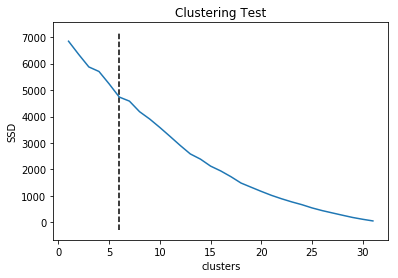

In [55]:
sum_squared_dist = []
K = range(1,32)
for k in K:
    km = KMeans(init="k-means++",n_clusters=k,n_init = 12,random_state=0)
    km = km.fit(X2)
    sum_squared_dist.append(km.inertia_)

%matplotlib inline

fig, ax = plt.subplots()
ax.plot(K, sum_squared_dist)
ax.set(xlabel='clusters', ylabel='SSD',
       title='Clustering Test')
plt.vlines(6, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

In [58]:
kclusters=6
km = KMeans(init = "k-means++", n_clusters = kclusters, n_init = 12)
km.fit(X1)
labels1 = km.labels_
venues_grouped = venues_grouped.join(pd.DataFrame({"Cluster Labels":labels1}))
venues_grouped

,Area name,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Austrian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beach,Beer Bar,Beer Store,Bistro,Boarding House,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Canal,Canal Lock,Candy Store,Caribbean Restaurant,Chaat Place,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Liquor Store,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Restaurant,Road,Rock Club,Romanian Restaurant,Salad Place,Sandwich Place,Scenic Lookout,Sculpture Garden,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Smoothie Shop,Snack Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Train Station,Tram Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Cluster Labels
0,Barking and Dagenham,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

#### Visualise clusters on map of London

In [60]:
address = 'London,UK'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of London using latitude and longitude values
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=10)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(boro_data['Latitude'], boro_data['Longitude'], venues_grouped['Area name'], venues_grouped['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2

#### Examine most popular venues in each cluster

In [61]:
venues_grouped_by_cluster = venues_grouped.groupby("Cluster Labels").mean().reset_index()

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Cluster Labels']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Cluster Labels'] = venues_grouped_by_cluster['Cluster Labels']

for ind in np.arange(venues_grouped_by_cluster.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped_by_cluster.iloc[ind, :], num_top_venues)

venues_sorted

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Park,Grocery Store,Italian Restaurant,Train Station,Indian Restaurant,Pub,Bakery,Fast Food Restaurant,Burger Joint,Bar
1,1,Pub,Coffee Shop,English Restaurant,Home Service,Playground,Bus Station,Tram Station,Café,Thai Restaurant,Clothing Store
2,2,Pub,Coffee Shop,Café,Bar,Park,Italian Restaurant,Fast Food Restaurant,Restaurant,Hotel,Gym
3,3,Pub,Coffee Shop,Fast Food Restaurant,Indian Restaurant,Hotel,Pharmacy,Clothing Store,Park,Chinese Restaurant,Grocery Store
4,4,Pub,Café,Coffee Shop,Italian Restaurant,Burger Joint,Plaza,Clothing Store,Outdoor Sculpture,Garden,Historic Site
5,5,Bus Stop,Grocery Store,Liquor Store,Convenience Store,Boat or Ferry,Pub,Pizza Place,Bar,Market,Garden


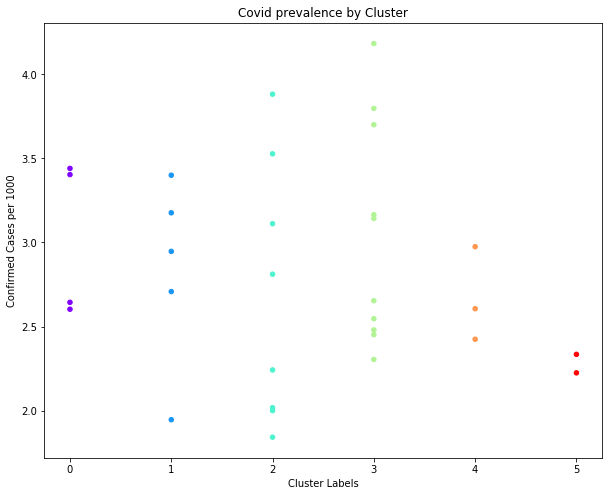

In [62]:
cv_by_venues_clusters = venues_grouped[["Area name","Cluster Labels"]].set_index(["Area name"]).join(london_data[["Area name","Prevalence rate"]].set_index(["Area name"])).reset_index()
cv_by_venues_clusters["Confirmed Cases per 1000"] = cv_by_venues_clusters["Prevalence rate"]*1000 # cases per 1000 people

color_sequence = []
for i in cv_by_venues_clusters["Cluster Labels"]:
    color_sequence.append(rainbow[i])
    
ax = cv_by_venues_clusters.plot.scatter(x="Cluster Labels",
                                        y="Confirmed Cases per 1000",
                                        c=color_sequence,
                                        figsize=(10,8),
                                        title="Covid prevalence by Cluster")